In [1]:
import DataLoading
from torch.utils.data import DataLoader,TensorDataset
import torch
import pandas as pd
import NN_classes
import training_methods
import seaborn as sns
import matplotlib.pyplot as plt

In [4]:
sc = "sc01"
period = "2030"
folder = "../Data/RTS24_AC_12w"
all_executions = DataLoading.list_executions(folder="../Data/RTS24_AC_12w",per = period,sc=sc)
executions = all_executions[1:20]
te_s = 0.3
val_s = 0.4

In [5]:
dfs_in,dfs_out = DataLoading.load_data(folder,executions,period,sc)

input_f_sc01_Network_Line_In_N_101_N_102_cac1_2030.csv
1227
input_f_sc01_Network_Line_In_N_101_N_103_cac1_2030.csv
1227
input_f_sc01_Network_Line_In_N_101_N_105_cac1_2030.csv
1227
input_f_sc01_Network_Line_In_N_102_N_104_cac1_2030.csv
1227
input_f_sc01_Network_Line_In_N_102_N_106_cac1_2030.csv
1227
input_f_sc01_Network_Line_In_N_103_N_109_cac1_2030.csv
1227
input_f_sc01_Network_Line_In_N_103_N_124_cac1_2030.csv
1227
input_f_sc01_Network_Line_In_N_104_N_109_cac1_2030.csv
1227
input_f_sc01_Network_Line_In_N_105_N_110_cac1_2030.csv
1227
input_f_sc01_Network_Line_In_N_106_N_108_cac1_2030.csv
1227
input_f_sc01_Network_Line_In_N_106_N_110_cac1_2030.csv
1227
input_f_sc01_Network_Line_In_N_107_N_108_cac1_2030.csv
1227
input_f_sc01_Network_Line_In_N_108_N_109_cac1_2030.csv
1227
input_f_sc01_Network_Line_In_N_108_N_110_cac1_2030.csv
1227
input_f_sc01_Network_Line_In_N_109_N_111_cac1_2030.csv
1227
input_f_sc01_Network_Line_In_N_109_N_112_cac1_2030.csv
1227
input_f_sc01_Network_Line_In_N_110_N_111

In [6]:
ts_in,ts_out =  DataLoading.split_tr_val_te_by_exec(dfs_in,dfs_out,executions,te_s,val_s,False)

In [8]:
d_ft_in, d_ft_out,maxs = DataLoading.concat_and_normalize_split_by_exec(ts_in,ts_out,executions)

In [9]:
train = TensorDataset(d_ft_in['train'].float(), d_ft_out['train'].float())
validation = TensorDataset(d_ft_in['val'].float(), d_ft_out['val'].float())

training_loader = DataLoader(train,batch_size=64)
validation_loader = DataLoader(train,batch_size=64)

In [11]:
learning_rates = [0.01*4**i for i in range(1)]
loss_fn = torch.nn.MSELoss()
nbs_e = [8]#,4,8]
i=0
nbs_hidden = [2]
dors = [0.1]
results = pd.DataFrame()
folder_to_save = "RTS24_AC_12w_split_by_exec_test"
for nb_e in nbs_e:
    for lr in learning_rates:
        for nb_hidden in nbs_hidden: 
            for dor in dors:
                m = NN_classes.create_model(nb_hidden,d_ft_in['train'].shape[1],dropout_ratio= dor)
                m_name = f"OE_{nb_hidden}h_{nb_e}e_{lr}lr_{dor}dor"
                optimizer = torch.optim.Adam(m.parameters(), lr=lr)
                train_loss = training_methods.train_multiple_epochs(nb_e,m,training_loader,validation_loader,loss_fn,optimizer,m_name,folder_to_save)

                saved_models = dict()

                for mt in ["min_val","all_epochs"]:
                    path = f"trained_models/{folder_to_save}/{mt}/model_{m_name}.pth"


                    model = m
                    m.load_state_dict(torch.load(path))
                    m.eval()

                    test_predictions = m(d_ft_in["test"].float())
                    test_loss = loss_fn(test_predictions,d_ft_out["test"])

                    train_predictions = m(d_ft_in["train"].float())
                    train_loss = loss_fn(train_predictions,d_ft_out["train"])

                    validation_prediction = m(d_ft_in["val"].float())
                    validation_loss = loss_fn(validation_prediction,d_ft_out["val"])

                    if mt == "min_val": 
                        min_val = True
                    else: 
                        min_val = False

                    r = pd.DataFrame({"Model_type": nb_hidden,
                                      "Min_val":min_val,
                                      "Epochs": nb_e,
                                      "Lr":lr,
                                      "Dor": dor,
                                      "Tr_l":train_loss.item(),
                                      "Te_l":test_loss.item(),
                                      "V_l": validation_loss.item()}
                                     ,index = [i]
                    )
                    i+=1
                    results = pd.concat([results,r])

ObjectiveEstimator_ANN_2hidden_layer(
  (hidden_layer1): Linear(in_features=1227, out_features=35, bias=True)
  (hidden_layer2): Linear(in_features=35, out_features=5, bias=True)
  (dropout): Dropout(p=0.1, inplace=False)
  (output_layer): Linear(in_features=5, out_features=1, bias=True)
) 0.1 2
EPOCH 1:
  batch 1 loss: 0.0011315090209245682
  batch 101 loss: 0.006558007273124531
  batch 201 loss: 0.0003304575479705818


C:\Workdir\Programs\Miniconda\envs\jr23\lib\site-packages\torch\nn\modules\loss.py:536: UserWarning: Using a target size (torch.Size([64])) that is different to the input size (torch.Size([64, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


LOSS train 0.0029516955017862816 valid 4.8309648263966665e-05
EPOCH 2:
  batch 1 loss: 5.641580355586484e-07
  batch 101 loss: 4.58279087797564e-05
  batch 201 loss: 0.00011503594835517106
LOSS train 9.191568257714967e-05 valid 5.2069342928007245e-05
EPOCH 3:
  batch 1 loss: 3.211701914551668e-07
  batch 101 loss: 0.00011333132302070226
  batch 201 loss: 9.883364376833014e-05
LOSS train 0.00010089338529986399 valid 7.607098086737096e-05
EPOCH 4:
  batch 1 loss: 1.4616898624808528e-08
  batch 101 loss: 8.174774459121181e-05
  batch 201 loss: 7.278307785099969e-05
LOSS train 7.37411346129929e-05 valid 0.00011422880197642371
EPOCH 5:
  batch 1 loss: 1.3300888895173558e-07
  batch 101 loss: 6.447547006473542e-05
  batch 201 loss: 6.074844860791018e-05
LOSS train 6.067989536421296e-05 valid 0.00014248921070247889
EPOCH 6:
  batch 1 loss: 2.713132198550738e-07
  batch 101 loss: 5.793076554084564e-05
  batch 201 loss: 5.725712409798689e-05
LOSS train 5.6633282217126016e-05 valid 0.00016909370

C:\Workdir\Programs\Miniconda\envs\jr23\lib\site-packages\torch\nn\modules\loss.py:536: UserWarning: Using a target size (torch.Size([13104])) that is different to the input size (torch.Size([13104, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
C:\Workdir\Programs\Miniconda\envs\jr23\lib\site-packages\torch\nn\modules\loss.py:536: UserWarning: Using a target size (torch.Size([17472])) that is different to the input size (torch.Size([17472, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
C:\Workdir\Programs\Miniconda\envs\jr23\lib\site-packages\torch\nn\modules\loss.py:536: UserWarning: Using a target size (torch.Size([10920])) that is different to the input size (torch.Size([10920, 1])). This will likely lead to incorrect results due to broadca

In [62]:
results.to_csv("Loss_results_csv/20Exec_split_by_exec.csv")

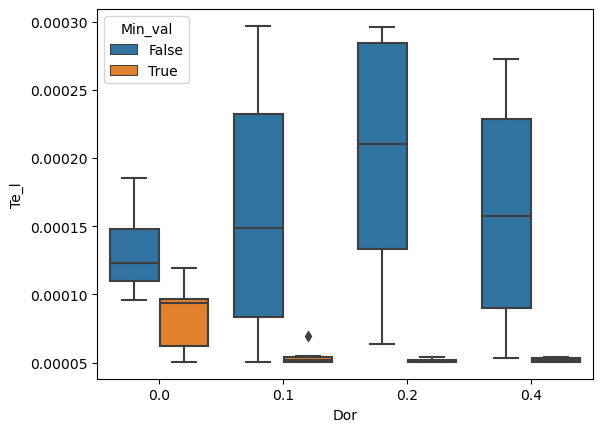

In [48]:
f = (results.Epochs == 12)  & (results.Model_type != 0) 
sns.boxplot(y = "Te_l",x="Dor",data = results[f],hue = "Min_val")
plt.savefig("Figures/Split_by_exec/Min_val_effect_Testloss_fDor.png")

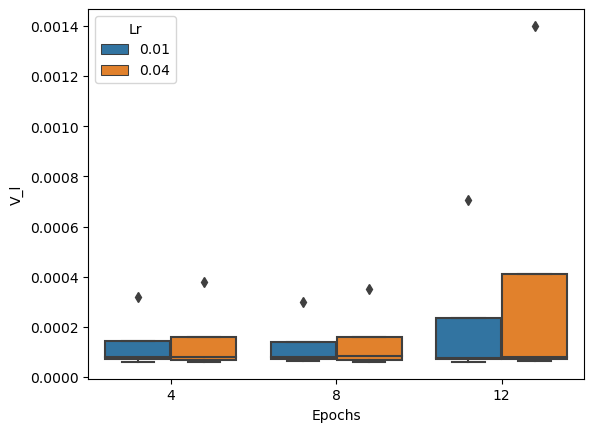

In [61]:
f =  (results.Model_type == 0) & (results.Min_val == True)
sns.boxplot(y = "V_l",x="Epochs",data = results[f],hue = "Lr")
plt.savefig("Figures/Split_by_exec/Lr_effect_Testloss_fEpochs.png")